# Notebook 06 — Model Interpretability (Permutation Importance)

Dieses Notebook deckt folgende Anforderungen ab:
- **Anforderung 8:** Evaluation (ergänzend: interpretierbare Ergebnisdarstellung)
- **Anforderung 9:** Diskussion/Interpretation (Treiber der Vorhersage und Einordnung)

Ziel:
- Quantifizieren, welche Features im HistGBR-Modell die Vorhersageleistung treiben, mittels **Permutation Importance**.

Vorgehen:
1. Laden der gewählten HistGBR-Konfiguration aus Notebook 05
2. Reproduzierbarer Train/Hold-out Split (identisch zu Notebook 04/05)
3. Training des Modells auf Train
4. Permutation Importance auf Hold-out (MAE als Kriterium)
5. Export als CSV + Plot

Outputs:
- `data_derived/06_permutation_importance_histgbr.csv`
- `plots/06_permutation_importance_histgbr.png`

In [3]:
from __future__ import annotations

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error, make_scorer

SEED = 42
np.random.seed(SEED)

def find_repo_root(start: Path) -> Path:
    start = start.resolve()
    for p in [start] + list(start.parents):
        if (p / "data" / "processed").exists():
            return p
    return start

REPO_ROOT = find_repo_root(Path.cwd())

PATH_MODEL_READY = REPO_ROOT / "data" / "processed" / "model_ready.csv"
PATH_DERIVED = REPO_ROOT / "data_derived"
PATH_PLOTS = REPO_ROOT / "plots"

PATH_DERIVED.mkdir(parents=True, exist_ok=True)
PATH_PLOTS.mkdir(parents=True, exist_ok=True)

TARGET = "moving_time"

def savefig(filename: str, dpi: int = 300) -> Path:
    path = PATH_PLOTS / filename
    plt.savefig(path, dpi=dpi, bbox_inches="tight")
    return path

print("REPO_ROOT:", REPO_ROOT)
print("PATH_MODEL_READY:", PATH_MODEL_READY)
print("PATH_DERIVED:", PATH_DERIVED)
print("PATH_PLOTS:", PATH_PLOTS)

REPO_ROOT: /Users/justuspfeifer/Documents/AML/aml-justus-pfeifer
PATH_MODEL_READY: /Users/justuspfeifer/Documents/AML/aml-justus-pfeifer/data/processed/model_ready.csv
PATH_DERIVED: /Users/justuspfeifer/Documents/AML/aml-justus-pfeifer/data_derived
PATH_PLOTS: /Users/justuspfeifer/Documents/AML/aml-justus-pfeifer/plots


In [4]:
# Daten laden
if not PATH_MODEL_READY.exists():
    raise FileNotFoundError(
        "[ERROR] model_ready.csv nicht gefunden.\n"
        f"Erwarteter Pfad: {PATH_MODEL_READY}\n"
        "Bitte Notebook 02 ausführen."
    )

df = pd.read_csv(PATH_MODEL_READY)
print("model_ready geladen:", df.shape)

FEATURES_HGBR = [
    "distance",
    "total_elevation_gain",
    "highest_elevation",
    "lowest_elevation",
    "distance_km",
    "elev_gain_per_km",
    "elev_range",
]

missing = [c for c in FEATURES_HGBR + [TARGET] if c not in df.columns]
if missing:
    raise ValueError(f"[ERROR] Erwartete Spalten fehlen in model_ready.csv: {missing}")

X = df[FEATURES_HGBR].copy()
y = df[TARGET].astype(float).copy()

# Split identisch zu Notebook 04/05
X_train, X_holdout, y_train, y_holdout = train_test_split(
    X, y, test_size=0.20, random_state=SEED
)
print("Train:", X_train.shape, "Hold-out:", X_holdout.shape)

# Gewählte Parameter aus Notebook 05 laden
params_path = PATH_DERIVED / "05_histgbr_selected_params.csv"
if not params_path.exists():
    raise FileNotFoundError(
        "[ERROR] 05_histgbr_selected_params.csv nicht gefunden.\n"
        f"Erwarteter Pfad: {params_path}\n"
        "Bitte Notebook 05 ausführen (Mini-Tuning + Parameterauswahl)."
    )

selected = pd.read_csv(params_path).iloc[0].to_dict()

HGBR_PARAMS = {
    "max_depth": int(selected["max_depth"]),
    "learning_rate": float(selected["learning_rate"]),
    "max_iter": int(selected["max_iter"]),
    "random_state": SEED,
}

model = HistGradientBoostingRegressor(**HGBR_PARAMS)
model.fit(X_train, y_train)

baseline_mae = mean_absolute_error(y_holdout, model.predict(X_holdout))
print("Rekonstruierter HistGBR trainiert. Hold-out MAE (nur Referenz):", f"{baseline_mae:.2f}s")
print("Params:", HGBR_PARAMS)

model_ready geladen: (9236, 9)
Train: (7388, 7) Hold-out: (1848, 7)
Rekonstruierter HistGBR trainiert. Hold-out MAE (nur Referenz): 583.16s
Params: {'max_depth': 8, 'learning_rate': 0.05, 'max_iter': 300, 'random_state': 42}


## Permutation Importance (Hold-out, MAE)

Permutation Importance misst den Leistungsabfall, wenn ein Feature zufällig permutiert wird.
Wir verwenden als Kriterium den **MAE (Sekunden)**:

- **positiver Wert** = MAE steigt → Feature ist wichtig
- **Wert nahe 0** = Feature trägt (in diesem Setup) kaum zur Vorhersage bei

In [5]:
# Manuelle Permutation Importance auf Hold-out (MAE-Anstieg, eindeutig positiv = wichtiger)

y_pred_base = model.predict(X_holdout)
mae_base = mean_absolute_error(y_holdout, y_pred_base)
print("Baseline MAE (Hold-out):", f"{mae_base:.2f}s")

rng = np.random.default_rng(SEED)
n_repeats = 20

rows = []
X_ref = X_holdout.copy()

for col in X_ref.columns:
    maes = []
    for _ in range(n_repeats):
        X_perm = X_ref.copy()
        X_perm[col] = rng.permutation(X_perm[col].values)
        pred = model.predict(X_perm)
        maes.append(mean_absolute_error(y_holdout, pred))

    maes = np.array(maes, dtype=float)
    rows.append({
        "feature": col,
        "mae_increase_s": float(maes.mean() - mae_base),
        "mae_increase_std_s": float(maes.std(ddof=1)),
    })

perm_df = pd.DataFrame(rows).sort_values("mae_increase_s", ascending=False).reset_index(drop=True)
display(perm_df)

out_path = PATH_DERIVED / "06_permutation_importance_histgbr.csv"
perm_df.to_csv(out_path, index=False)
print("Saved:", out_path)

Baseline MAE (Hold-out): 583.16s


,feature,mae_increase_s,mae_increase_std_s
0,distance,3.595260e+03,5.686223e+01
1,total_elevation_gain,4.148155e+02,1.096061e+01
2,highest_elevation,1.468966e+02,7.538070e+00
3,lowest_elevation,1.462370e+02,1.045634e+01
4,elev_range,1.126343e+02,4.953345e+00
5,elev_gain_per_km,1.069435e+02,7.548858e+00
6,distance_km,-1.136868e-13,1.166402e-13


Saved: /Users/justuspfeifer/Documents/AML/aml-justus-pfeifer/data_derived/06_permutation_importance_histgbr.csv


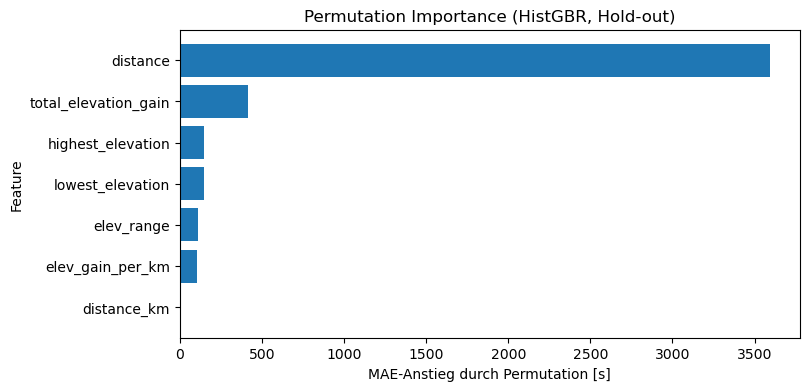

Saved: /Users/justuspfeifer/Documents/AML/aml-justus-pfeifer/plots/06_permutation_importance_histgbr.png
Top-Treiber: distance > total_elevation_gain > highest_elevation | MAE-Anstieg [s]: 3595.3, 414.8, 146.9


In [6]:
plt.figure(figsize=(8, 4))
plt.barh(perm_df["feature"], perm_df["mae_increase_s"])
plt.xlabel("MAE-Anstieg durch Permutation [s]")
plt.ylabel("Feature")
plt.title("Permutation Importance (HistGBR, Hold-out)")
plt.gca().invert_yaxis()

plot_path = savefig("06_permutation_importance_histgbr.png", dpi=300)
plt.show()

print("Saved:", plot_path)

top = perm_df.head(3)
print(
    "Top-Treiber:",
    " > ".join(top["feature"].tolist()),
    "| MAE-Anstieg [s]:",
    ", ".join([f"{v:.1f}" for v in top["mae_increase_s"].tolist()])
)

## Interpretation der Feature-Wichtigkeit

Die Permutation Importance zeigt, welche Features die Vorhersageleistung des HistGBR auf dem Hold-out Datensatz am stärksten beeinflussen:

- **`distance`** ist mit Abstand der wichtigste Treiber. Wird `distance` permutiert, steigt der MAE um ca. **+3595 s**.
- Danach folgen **`total_elevation_gain`** (ca. **+415 s**) sowie die Höhenlage über **`highest_elevation`** (ca. **+147 s**).
- Weitere topografische Merkmale (`lowest_elevation`, `elev_range`, `elev_gain_per_km`) tragen zusätzlich bei, aber deutlich schwächer.

**Redundanz-Hinweis:**  
`distance_km` zeigt eine Wichtigkeit nahe 0, da dieses Feature eine direkte Umrechnung von `distance` ist und daher keine zusätzliche Information liefert (starke Redundanz/Korrelation).

In [7]:
top_path = PATH_DERIVED / "06_permutation_importance_top3.csv"
perm_df.head(3).to_csv(top_path, index=False)
print("Saved:", top_path)

display(perm_df.head(7))

Saved: /Users/justuspfeifer/Documents/AML/aml-justus-pfeifer/data_derived/06_permutation_importance_top3.csv


,feature,mae_increase_s,mae_increase_std_s
0,distance,3.595260e+03,5.686223e+01
1,total_elevation_gain,4.148155e+02,1.096061e+01
2,highest_elevation,1.468966e+02,7.538070e+00
3,lowest_elevation,1.462370e+02,1.045634e+01
4,elev_range,1.126343e+02,4.953345e+00
5,elev_gain_per_km,1.069435e+02,7.548858e+00
6,distance_km,-1.136868e-13,1.166402e-13
